In [1]:
import torch
from torch.utils.data import DataLoader
from my_helper import *

from hamer.models import load_hamer
from hamer.utils import recursive_to
from hamer.datasets.vitdet_dataset import ViTDetDataset

/home/jikaiwang/mambaforge/envs/hamer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Initialize HaMeR Model

In [2]:
hamer_checkpoint = f"{PROJ_ROOT}/_DATA/hamer_ckpts/checkpoints/hamer.ckpt"
rescale_factor = 2.0
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the model from the checkpoint
hamer_model, hamer_cfg = load_hamer(hamer_checkpoint)

# Move the model to the GPU
hamer_model = hamer_model.to(device)

# Set the model to evaluation mode
hamer_model = hamer_model.eval()


#  Load Data from Recording

In [3]:
sequence_folder = PROJ_ROOT / "data/recordings/ida_20240617_101133"
hand_detection_folder = sequence_folder / "processed/hand_detection"

## Load Metadata

In [4]:
meta_file = sequence_folder / "meta.json"
data = read_data_from_json(meta_file)

serials = data["serials"]
width = data["width"]
height = data["height"]
num_frames = data["num_frames"]
mano_sides = data["mano_sides"]

In [5]:
print(f"Serials: {serials}")
print(f"Width: {width}")
print(f"Height: {height}")
print(f"Num frames: {num_frames}")
print(f"Mano sides: {mano_sides}")

Serials: ['037522251142', '043422252387', '046122250168', '105322251225', '105322251564', '108222250342', '115422250549', '117222250549']
Width: 640
Height: 480
Num frames: 552
Mano sides: ['right', 'left']


## Load Bounding Box

In [6]:
landmarks = np.load(hand_detection_folder / "mp_hand_joints_3d_projection.npz")

In [7]:
for key, marks in landmarks.items():
    print(f"key: {key}, boxes: {marks.shape}, {marks.dtype}")

key: 037522251142, boxes: (2, 552, 21, 2), int64
key: 043422252387, boxes: (2, 552, 21, 2), int64
key: 046122250168, boxes: (2, 552, 21, 2), int64
key: 105322251225, boxes: (2, 552, 21, 2), int64
key: 105322251564, boxes: (2, 552, 21, 2), int64
key: 108222250342, boxes: (2, 552, 21, 2), int64
key: 115422250549, boxes: (2, 552, 21, 2), int64
key: 117222250549, boxes: (2, 552, 21, 2), int64


## Load landmarks for frame '000100', camera '105322251564'

In [8]:
marks = landmarks["105322251564"][:,100,:]
print(f"marks: {marks.shape}, {marks.dtype}")

marks: (2, 21, 2), int64


## Visualize the boxes

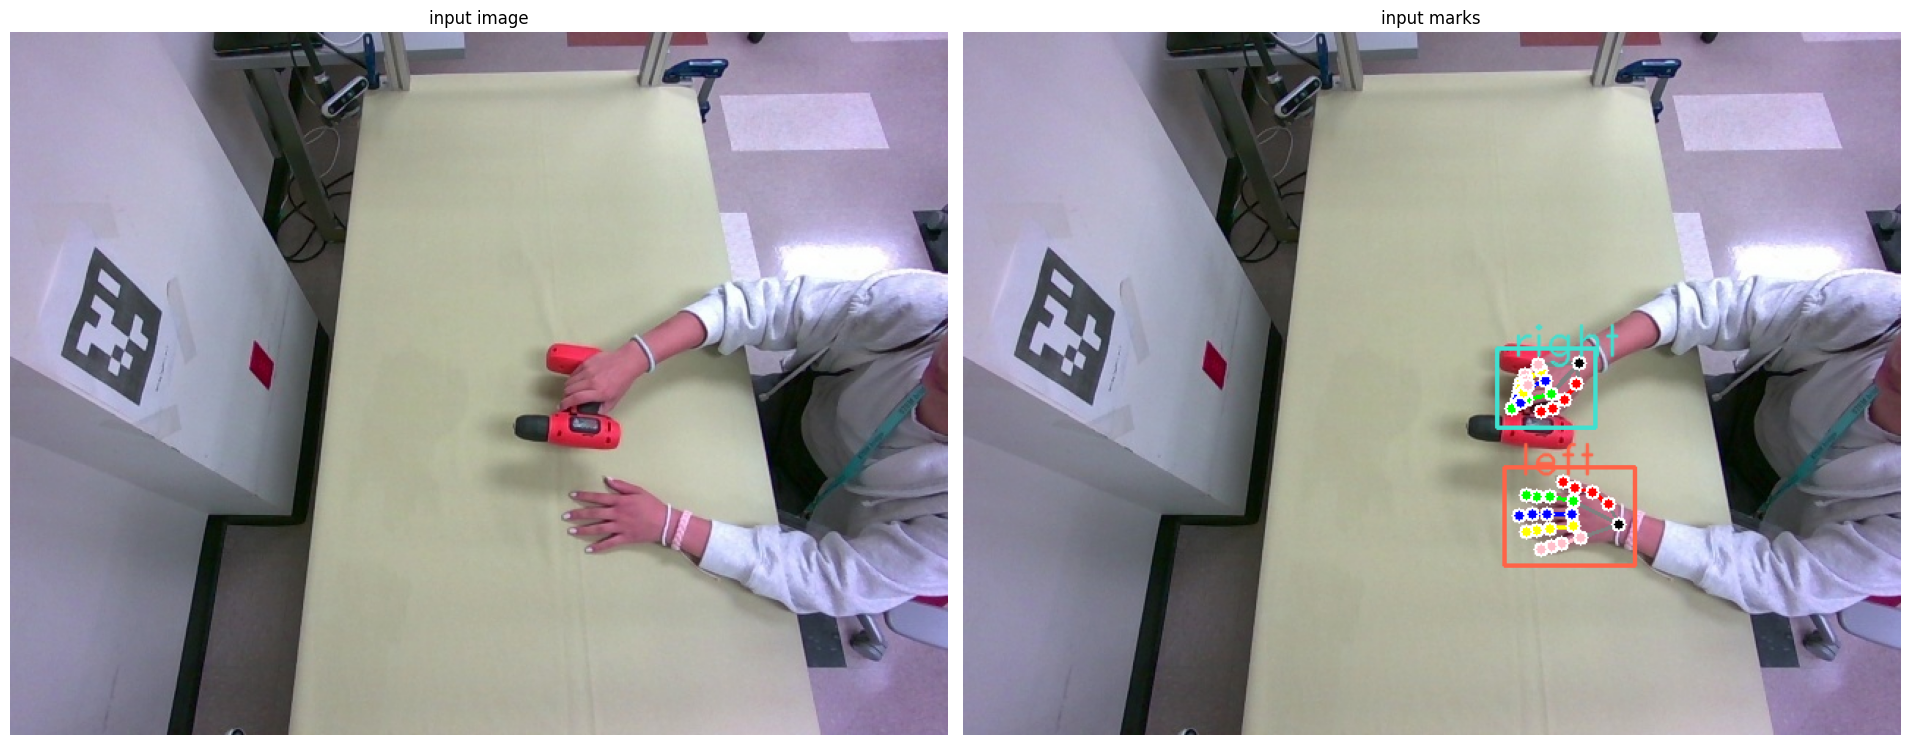

In [9]:
color_file = sequence_folder / "105322251564" / "color_000100.jpg"
rgb_image = read_rgb_image(color_file)
vis_input = draw_debug_image(
    rgb_image=rgb_image,
    hand_marks=marks,
    draw_boxes=True,
    draw_hand_sides=True,
)

display_images([rgb_image, vis_input], ["input image", "input marks"])

# Prepare Input Data for HaMeR Model

In [10]:
input_boxes = []
right_flags = []


for i, mks in enumerate(marks):
    box = get_bbox_from_landmarks(mks, width, height, margin=15)
    if np.any(box==-1):
        continue
    input_boxes.append(box)
    is_right = i==0
    right_flags.append(is_right)

input_boxes = np.array(input_boxes)
right_flags = np.array(right_flags)

print(f"input_boxes: {input_boxes.shape}, {input_boxes.dtype}")
print(input_boxes)

print(f"right_flags: {right_flags.shape}, {right_flags.dtype}")
print(right_flags)

input_boxes: (2, 4), int64
[[359 211 436 275]
 [364 292 463 369]]
right_flags: (2,), bool
[ True False]


# Run Inference on the Input Data

1. Bounding box conversion

![Bbox conversion](https://www.researchgate.net/profile/Mayura-Manawadu/publication/353609044/figure/fig2/AS:1051701863804928@1627756672274/Format-of-the-bounding-box-in-YOLO-network.png)

In [11]:
# Create a dataset
dataset = ViTDetDataset(
    cfg=hamer_cfg,
    img_cv2=cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB),
    boxes=input_boxes,
    right=right_flags,
    rescale_factor=rescale_factor,
)

# Create a dataloader for the dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

# Iterate over the dataloader
hamer_marks = np.full((2, 21, 2), -1, dtype=np.int64)
with torch.no_grad():
    for batch in dataloader:
        # Move the batch to the GPU
        batch = recursive_to(batch, device)

        # Forward pass
        out = hamer_model(batch)

        # Get the predicted landmarks
        box_center = batch["box_center"].float()
        box_size = batch["box_size"].float()
        right = batch["right"].long()
        kpts_2d = out["pred_keypoints_2d"].squeeze(0).float()

        print(f"box_center: {box_center.shape}, {box_center.dtype}, {box_center}")
        print(f"box_size: {box_size.shape}, {box_size.dtype}, {box_size}")
        print(f"right: {right.shape}, {right.dtype}, {right}")
        print(f"kpts_2d: {kpts_2d.shape}, {kpts_2d.dtype}, {kpts_2d.min()}, {kpts_2d.max()}")


        if right == 0:  # Flip the keypoints if the hand is left
            kpts_2d[:, 0] *= -1
        
        # Unnormalize the keypoints
        kpts_2d = kpts_2d * box_size + box_center
        kpts_2d = kpts_2d.cpu().numpy()

        # Store the keypoints
        hamer_marks[0 if right else 1] = kpts_2d

box_center: torch.Size([1, 2]), torch.float32, tensor([[397.5000, 243.0000]], device='cuda:0')
box_size: torch.Size([1]), torch.float32, tensor([205.3333], device='cuda:0')
right: torch.Size([1]), torch.int64, tensor([1], device='cuda:0')
kpts_2d: torch.Size([21, 2]), torch.float32, -0.10205139964818954, 0.12258590757846832
box_center: torch.Size([1, 2]), torch.float32, tensor([[413.5000, 330.5000]], device='cuda:0')
box_size: torch.Size([1]), torch.float32, tensor([264.], device='cuda:0')
right: torch.Size([1]), torch.int64, tensor([0], device='cuda:0')
kpts_2d: torch.Size([21, 2]), torch.float32, -0.1345556229352951, 0.13619078695774078


## Visualize the output landmarks from HaMeR model

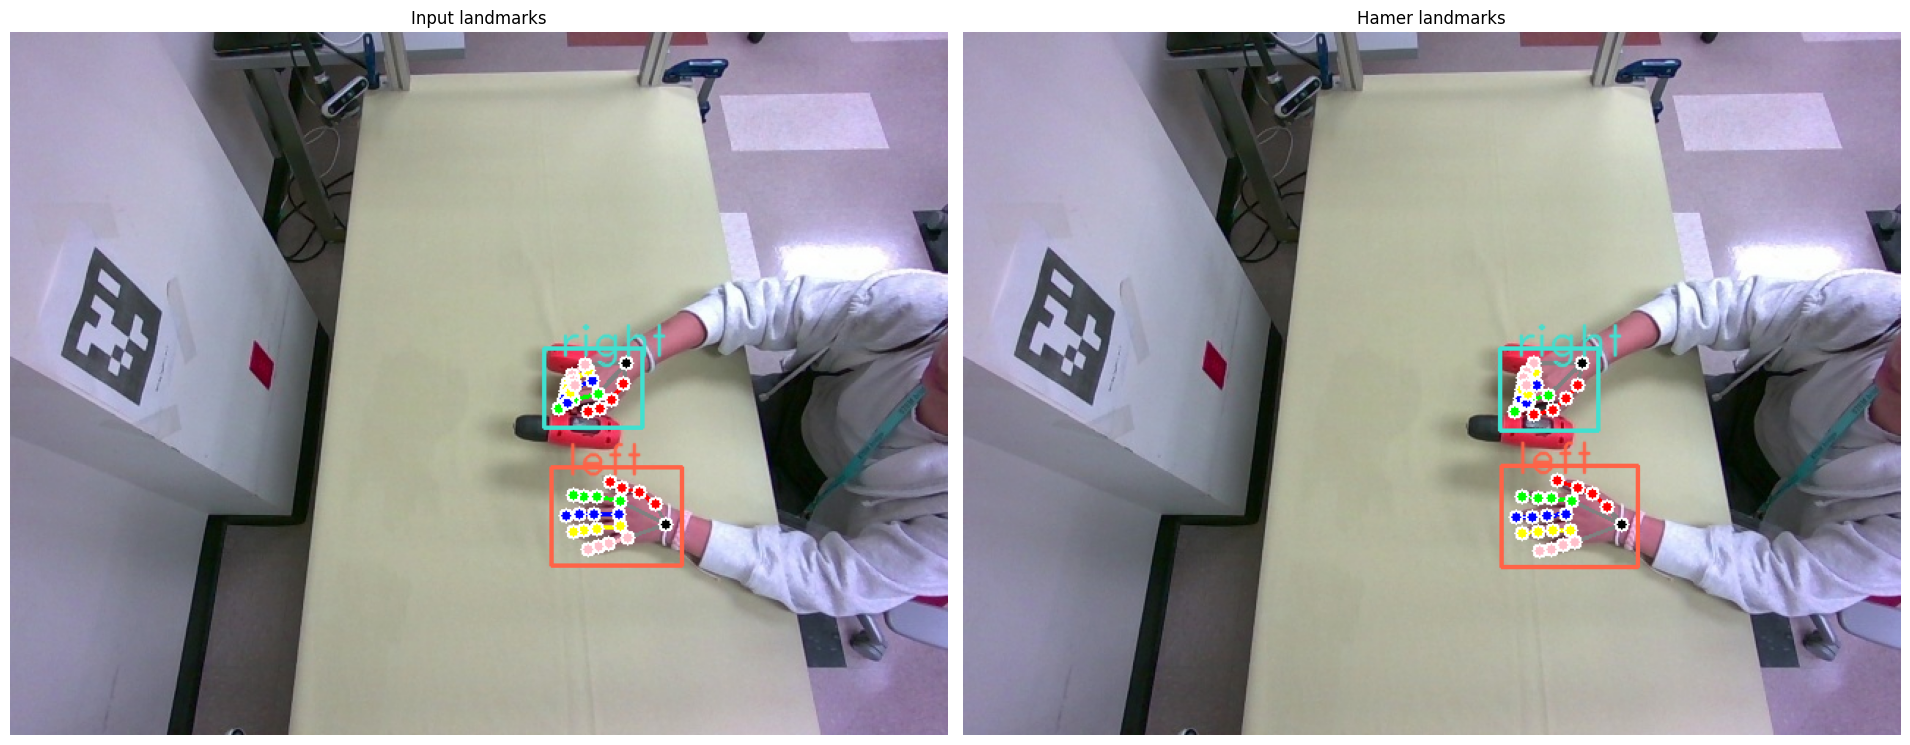

In [12]:
vis_hamer = draw_debug_image(
    rgb_image=rgb_image,
    hand_marks=hamer_marks,
    draw_boxes=True,
    draw_hand_sides=True,
)

display_images([vis_input, vis_hamer], ["Input landmarks", "Hamer landmarks"])